In this notebook, I will implement and compare Q-learning and Expected SARSA on the Frozen Lake task.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import sys
import torch
import torch.nn as nn
import gym

In [ ]:
min_epsilon = 0.01
max_epsilon = 1.0
decay_rate = 0.005
num_episodes = 25000
max_steps = 100
plot_every = 100

In [131]:
class QLearningAgent:
  def __init__(self, env, alpha, gamma):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.Q = np.zeros([env.observation_space.n, env.action_space.n])



  def epsilon_greedy(self, state, epsilon):
    if np.random.uniform(0,1) < epsilon:
      return env.action_space.sample()
    else:
      return np.argmax(self.Q[state][:])


  def train(self, num_episodes):
    rewards = []
    epsilon = 1.0
    stats_rewards = deque(maxlen=plot_every)
    avg_rewards = deque(maxlen=num_episodes)

    for episode in range(num_episodes):
      total_reward = 0
      state = env.reset()
      done = False

      for i in range(max_steps):
        action = self.epsilon_greedy(state, epsilon)
        next_state, reward, done, _ = self.env.step(action)
        total_reward+=reward
        self.Q[state][action] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state][:]) - self.Q[state][action])

        if done:
          epsilon = min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*episode)
          stats_rewards.append(total_reward)
          if (episode % plot_every == 0):
            avg_rewards.append(np.mean(stats_rewards))
          break
        state = next_state



    return self.Q, avg_rewards

  def evaluate(self, Q, num_episodes):
    total_rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
      state = env.reset()
      episode_reward = 0

      for i in range(max_steps):
        action = np.argmax(Q[state][:])
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state
        if done:
          total_rewards[episode] = episode_reward
          break
    return total_rewards



env = gym.make('FrozenLake-v1')
agent = QLearningAgent(env, alpha=0.8, gamma=.9)
Q_1, average_rewards_1 = agent.train(num_episodes)

In [155]:
tot_reward = agent.evaluate(Q_1, 100)
avg_reward = round(np.mean(tot_reward), 4)
print(f"Average reward: {avg_reward}")

Average reward: 0.73


##Note on update equation of Expected SARSA
Update Equation:

$$
Q(S_t, A_t) ← Q(S_t, A_t) + α \left(R_{t+1} + γ\mathbb{E}[ Q(S_{t+1}, A{t+1})\mid S_{t+1}] - Q(S_t, A_t)\right)
$$


Code explanation:

1. Each action initially has an equal chance of being selected. If the greedy action has been selected, the probability of choosing
the greedy action is increased by $1 - ϵ$, ensuring that this actions is more likely to be selected under an epsilon greedy policy.

2. The expected Q value for each state is calculated by taking the dot product of the Q values in state with policy probablities. This computation gives us the weighted average of the Q values based on how likely each action is to be taken under the current policy.



In [104]:
class ExpectedSarsa:
  def __init__(self, env, alpha, gamma):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.Q = np.zeros([env.observation_space.n, env.action_space.n])
    self.n_actions = env.action_space.n



  def epsilon_greedy(self, state, epsilon):
    if np.random.uniform(0,1) < epsilon:
      return env.action_space.sample()
    else:
      return np.argmax(self.Q[state][:])


  def train(self, num_episodes):
    rewards = np.zeros(num_episodes)
    epsilon = 1.0
    stats_rewards = deque(maxlen=plot_every)
    avg_rewards = deque(maxlen=num_episodes)

    for episode in range(num_episodes):

      total_reward = 0
      state = env.reset()
      done = False
      expected = 0

      for i in range(max_steps):
        action = self.epsilon_greedy(state, epsilon)
        next_state, reward, done, _ = self.env.step(action)
        total_reward += reward
        probs = np.ones(self.n_actions) * epsilon / self.n_actions
        probs[np.argmax(self.Q[next_state])] += (1.0 - epsilon)
        expected_Q = np.dot(self.Q[next_state], probs)
        self.Q[state][action] += self.alpha * (reward + self.gamma * (expected_Q - self.Q[state][action]))

        if done:
          epsilon = min_epsilon + (max_epsilon-min_epsilon) * np.exp(-decay_rate * episode)
          stats_rewards.append(total_reward)
          if (episode % plot_every == 0):
            avg_rewards.append(np.mean(stats_rewards))
          break
        state = next_state


    return self.Q, avg_rewards

  def evaluate(self, Q, num_episodes):
    total_rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
      state = env.reset()
      episode_reward = 0

      for i in range(max_steps):
        action = np.argmax(Q[state][:])
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state
        if done:
          total_rewards[episode] = episode_reward
          break

    return total_rewards




env = gym.make('FrozenLake-v1')
agent = ExpectedSarsa(env, alpha=0.8, gamma=.9)
Q_2, average_rewards_2 = agent.train(num_episodes)

In [109]:
tot_reward = agent.evaluate(Q_2, 100)
avg_reward = round(np.mean(tot_reward), 4)
print(f"Average reward: {avg_reward}")

Average reward: 0.75


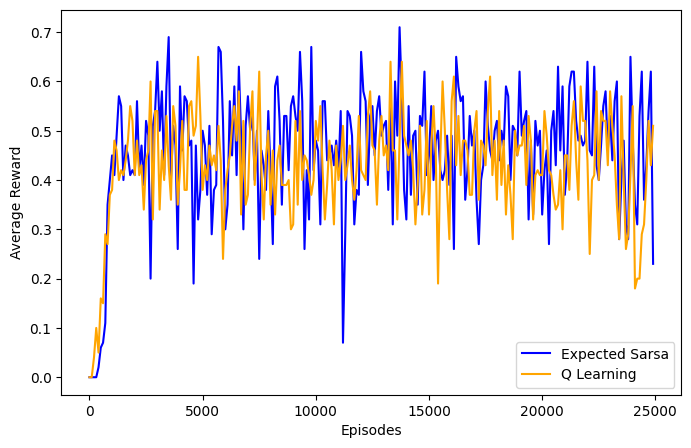

In [153]:
plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,num_episodes,len(average_rewards_2),endpoint=False), np.asarray(average_rewards_2), label = 'Expected Sarsa', color = 'blue')
plt.plot(np.linspace(0,num_episodes,len(average_rewards_1),endpoint=False), np.asarray(average_rewards_1), label = 'Q Learning', color = 'orange')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.show()